#### Climate data is observed and collected at various timescales from sub-hourly to annual. Depending of the climate phenomena we are interested in, it is common to have to convert a dataset from one timescale to another. Moving from a higher-frequency to a lower-frequency requires __temporal averaging__. You might need to use temporal averaging to convert from:
* #### hourly to daily.
* #### daily to weekly.
* #### daily to monthly.
* #### monthly to seasonal (winter, spring, summer, fall)
* #### monthly to annual.
* #### annual to multi-decadal
* #### multi-decadal to centennial
* #### and so on .....

#### This notebook walks through how to compute time-weighted temporal averages by computing __seasonal-mean__ and __annual-mean__ Sea Surface Temperature (SST) from a monthly SST climatological observational field. We are using NOAA's OI SST Monthly Mean 1982-2022 DataSet from https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html.

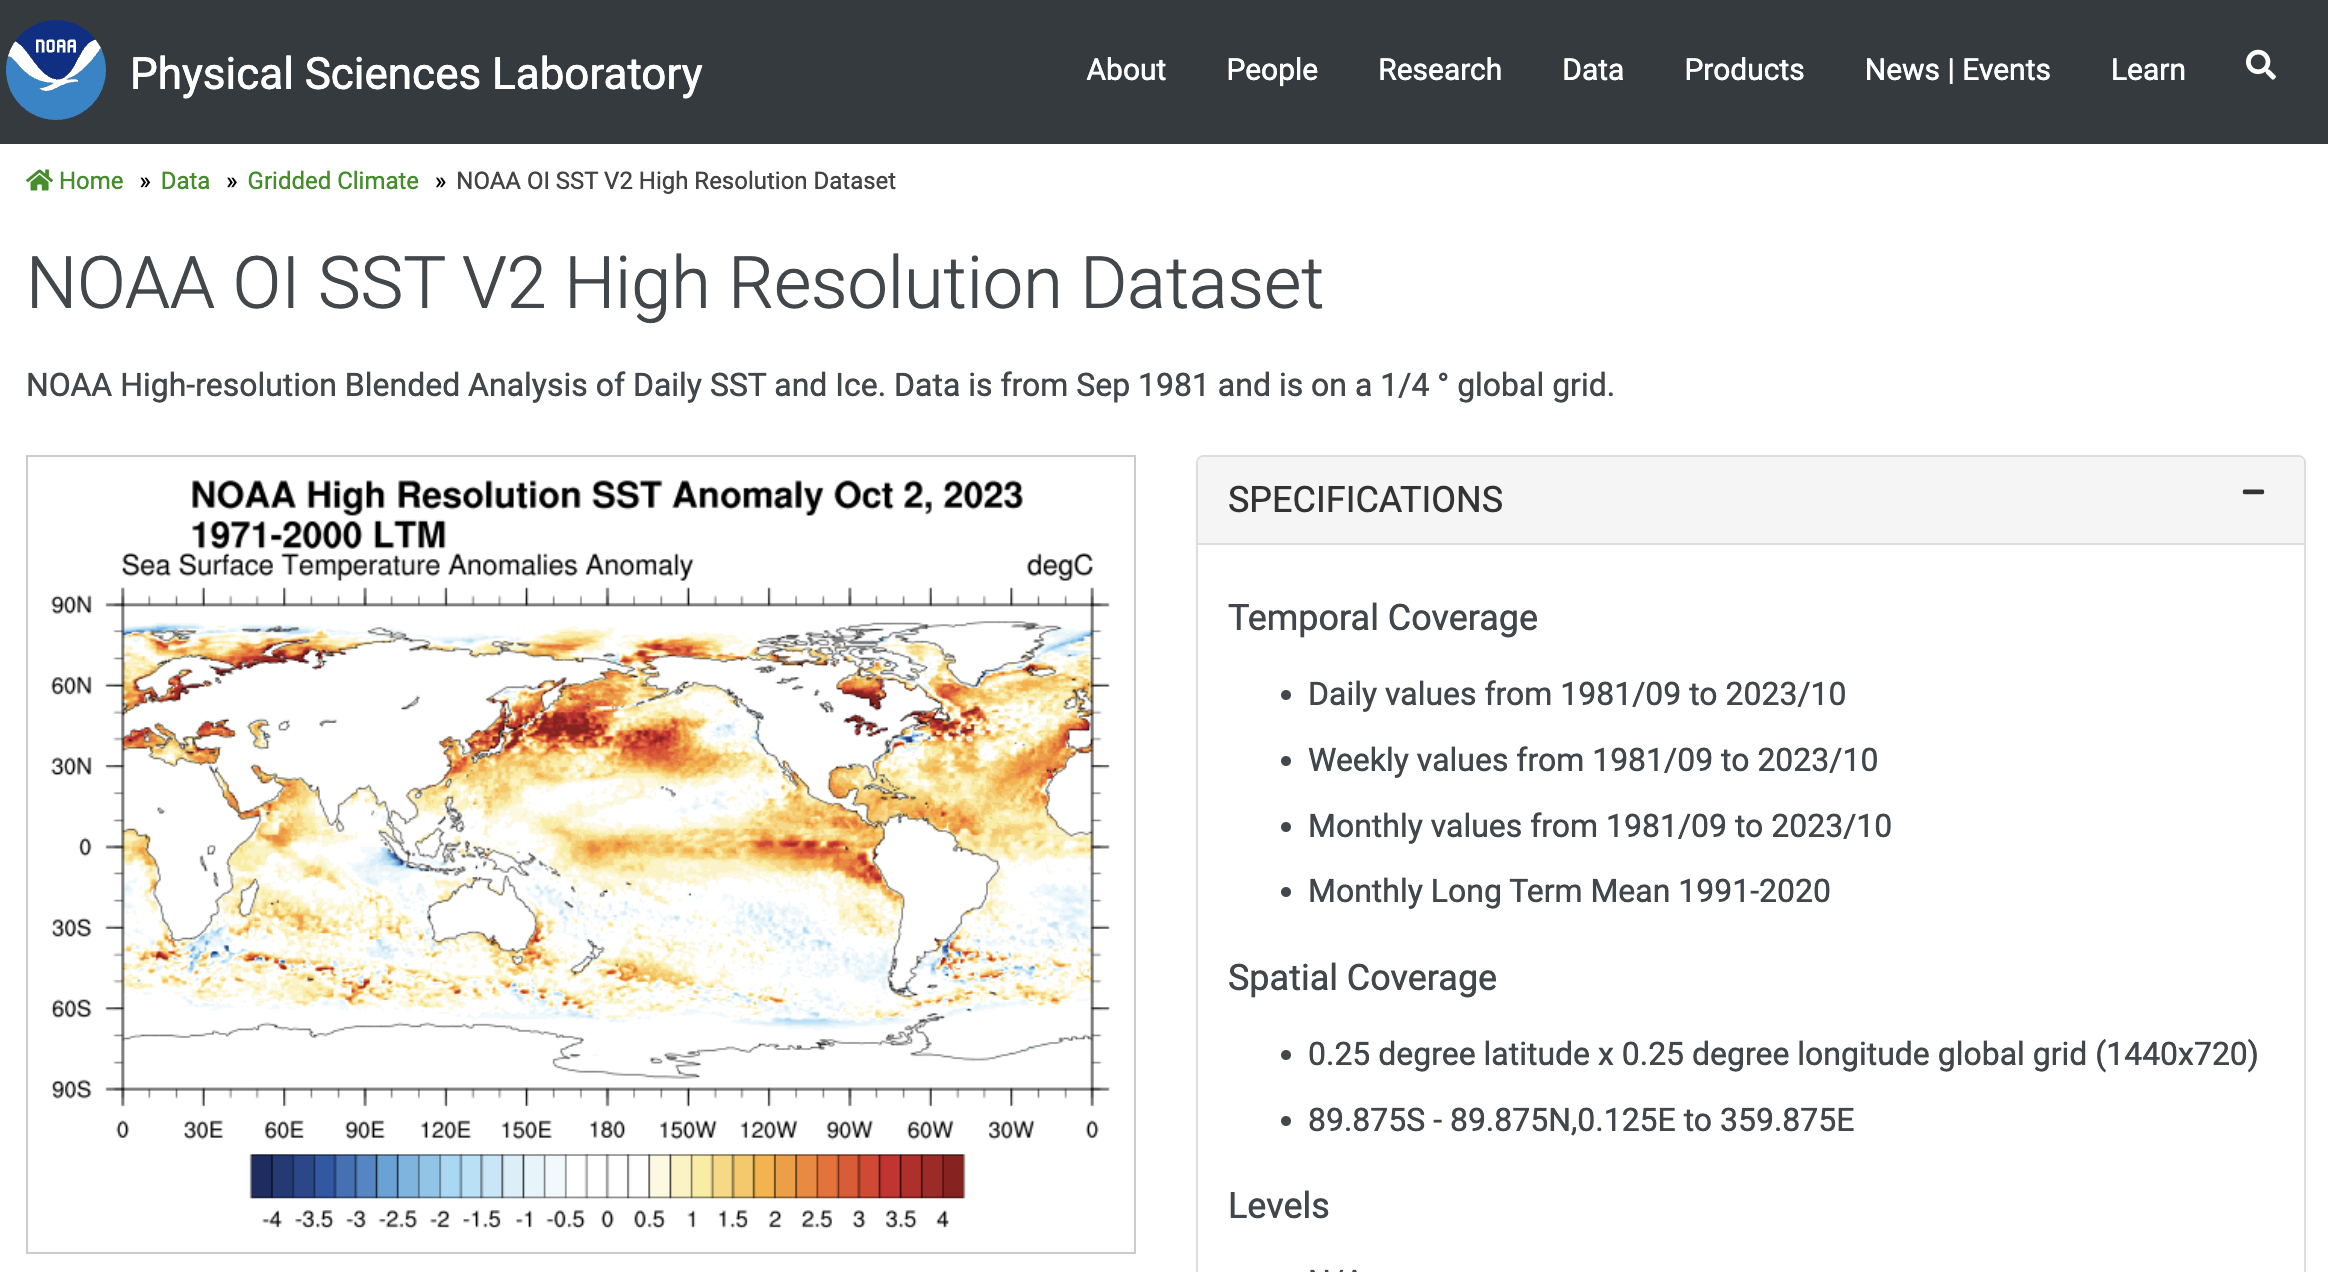

#### __Authors__: Dr. Rebecca L. Beadling, with pieces adapted from tutorial written by Will Ellinger. For any questions regarding the contents of this notebook please contact rebecca.beadling@temple.edu or william.ellinger@temple.edu.

#### You should be __entering__ this lesson with ...
* Having worked through all of the exercises in the Xarray_Fundamentals and Weighted_Averages_Spatial notebooks.
* An understanding of what a weighted average is.

#### You should be __leaving__ this lesson with ...
* An understanding of how to compute a properly weighted temporal average.
* The ability to take a monthly climate dataset and create and understand what the following are:
    - an annual-mean dataset
    - a annual-cycle dataset ("annual climatology")
    - a seasonal average across a particular time period (DJF, MAM, JJA, SON).
* Computing and visualizing differences computed from different time periods.

In [ ]:
import matplotlib.pyplot as plt 
import xarray as xr
import numpy as np 

In [ ]:
%matplotlib inline                           
%config InlineBackend.figure_format='retina' 
plt.rcParams['figure.figsize'] = 12,6  

#### Here we load in a Dataset of observed monthly-mean SST from OISST that contains data from January 1993 to Dec 2022. We also load in our land-sea mask for the dataset to be used later in a global mean calculation.

In [ ]:
## Load a dataset of SST from OISST and assign to a variable called SST_OISST:
SST_OISST = xr.open_dataset('/home/tu.temple.edu/tuo15329/xarray_unit4_woolslayer/data/sst.oisst.mon.mean.1993_2022.nc',
                           use_cftime=True)
                           ### this use_cftime=True allows Xarray to interpret time coords as calendar.

## load in a dataset that contains a land-sea mask:
OISST_landsea_mask = xr.open_dataset('/home/tu.temple.edu/tuo15329/xarray_unit4_woolslayer/data/lsmask.nc')

#### <span style="color:red"> Write code in the cell below that extracts our sst field from our Dataset we loaded in. Assign this to a new variable called `SST_monthly`.

In [ ]:
SST_monthly = SST_OISST.sst
SST_monthly

#### <span style="color:red"> Examine your `SST_monthly` DataArray and answer the following in the cell below:
* How many dimensions does your SST_monthly DataArray have? 
* What are the lengths of those dimensions?
* What are the coordinate values of your first and last time slices? 
* What coordinate values do your lat and lon dimensions span?

3 dimensions: time(360), lat(180), lon(360)
First time slice: (-89.5, 0.01)
Last time slice: (89.5, 359.0)
span over time from 1993-2022

#### We see that our DataArray has 360 time values, that is a lot! Let's first learn how to average this down from monthly to annual values. I will explain this conceptually and then give you a nice function from a package to do this for you.

#### Just like not all grid-cell areas are the same and we must take grid cell area into account when computing 2D spatial averages, when computing annual averages from monthly fields, not every month contributes evenly to the annual average! The days in the month differ! 
* #### June for instance only has 30 days, while July has 31 ..... so the month of July actually contributes more to the annual average!

#### To illustrate this point we can look at the days in each month for the first year of our `SST_monthly` DataArray. January has 31 days, so it contributes more to the annual mean than February which as only 28 days (for a non-leap calendar!). 

We can find the month length by using Xarray's `DataArray.dt.days_in_month.()` method which will compute the number of days in each month for each month of your array by accessing the coordinate information of your time dimension. 

In [ ]:
month_length = SST_monthly.time.dt.days_in_month
month_length

#### For illustrative purposes, we can slice out just the first year and see the number of days in each month spanning Jan 1993 to Dec 1993:

In [ ]:
month_length.sel(time=slice('1993-01-01','1993-12-01'))

#### We can compute the actual weights by then taking the days in the month divided by the total days in a year, for example 31 / 365 for January ... gives us a weight of 0.0849. We do this using Xarray's `groupby.()` method. We will cover this in more detail later, by the `.groupby()` method will group your DataArray by specific parameters. In this case it is grouping our month_length DataArray by year and then dividing by the sum of all the month lengths within that specific year to give us the "weight" each month contributes to the TOTAL length of the year:

__All this is doing is:__

* January_weight = 31 days / 365 days in the year == 0.0849
* Febuary_weight = 28 days / 365 days in the year == 0.0767 .... and so on

In [ ]:
month_weights = month_length.groupby('time.year') / month_length.groupby('time.year').sum()
month_weights.sel(time=slice('1993-01-01','1993-12-01'))

### In data analysis and programming in general, it is tempting to just jump in and start using packages and functions that make everything easy for you ..... but you need to understand what is going on behind the scenes to ensure you are doing the correct calculations.

#### <span style="color:red"> Explain in the cell below what a weighted average is and why we must use it when converting from monthly to annual data. How do we use weighted averages when working with spatial averages? What are our "weights" in that case?

A weighted average allows us to more accurately understand what impact each month has on a particular data set. As mentioned earlier, July has more impact because it has 31 days instead of 30 like June. We must account for the differences to eliminate as much bias as possible. When working with spatial averages, each grid block does not have the same area. As you get toward the poles, there is less area in a grid block than a grid space around the equator due to the fact the earth is round. The grid space discrepancy is the weight

#### Okay okay ... so now that you actually understand what a weighted average is .... I will let you in on the secret that there is a very useful Python package called __momlevel__ developed by John Krasting at NOAA's Geophysical Fluid Dynamics Laboratory (GFDL) that has a built in function, `util.annual_average()`, that allows one to compute annual means from any monthly DataArray. You can use this to save some time - but you should know what it is actually doing!

![](https://momlevel.readthedocs.io/en/v0.0.7/_static/momlevel_logo.png)

#### Read more about the momlevel package here: https://momlevel.readthedocs.io/en/v0.0.7/ and the annual_average utility here: https://momlevel.readthedocs.io/en/v0.0.7/api/momlevel.util.html

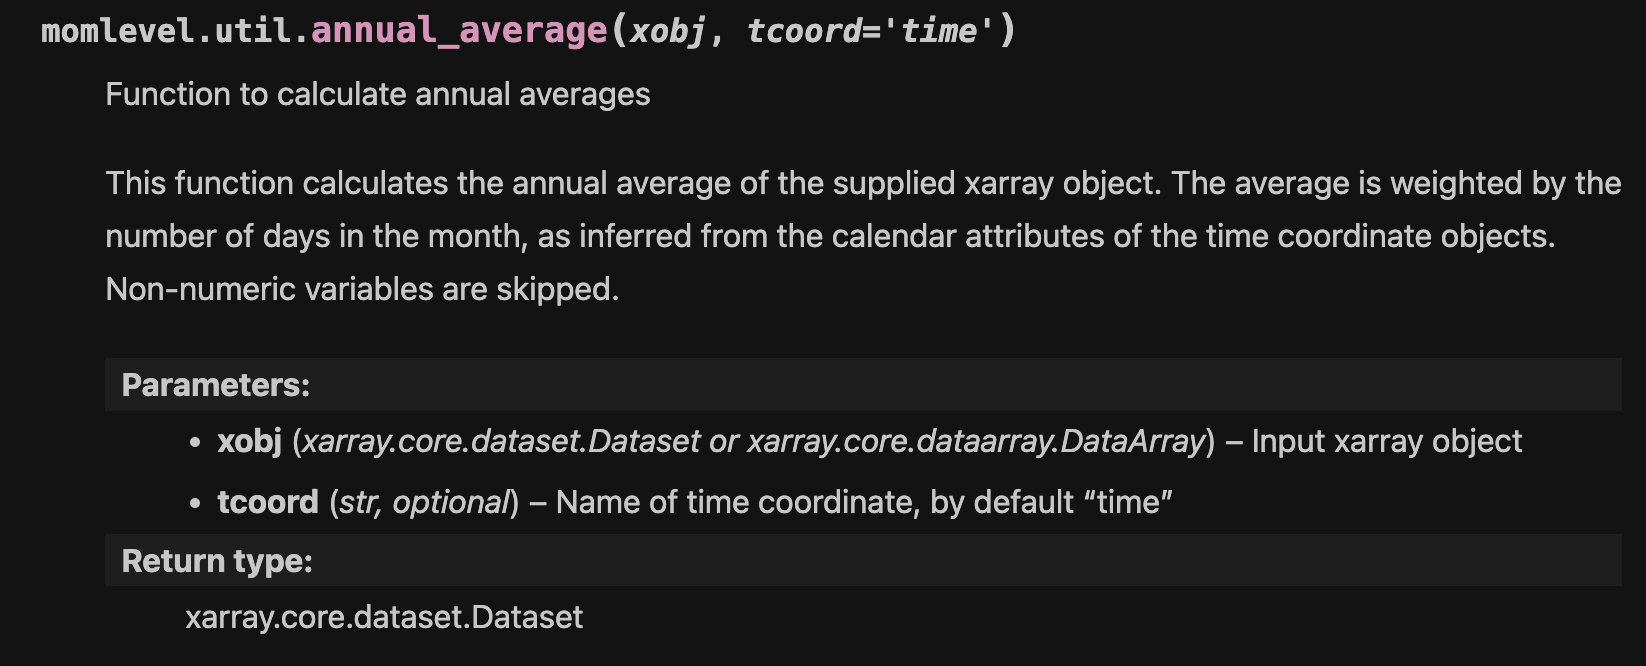

In [ ]:
import momlevel as ml   ## import momlevel and give it the alias ml
SST_annual = ml.util.annual_average(SST_monthly,tcoord='time')
SST_annual

#### <span style="color:red"> In the cell below examine your newly created `SST_annual` array: 
    * What is your time dimension now?
    * What are your first and last coordinate values of your time dimension?

time dimension is 30, First:-1.57093671 Last:-1.71415899

#### <span style="color:red">  In the cell below use Xarray's `.plot()` method to create a plot of annual-mean global SSTs in the year 1997:

In [ ]:
sst_1997=SST_annual.sel(time=slice('1997-01-01','1997-12-01')).plot()

#### <span style="color:red">  In the cell below use Xarray's `.plot()` method to create a plot of annual-mean global SSTs in the year 2022:

In [ ]:
sst_2022=SST_annual.sel(time=slice('2022-01-01','2022-12-01')).plot()

#### Now in the cells below we can define variables equal to our SST_1997 DataArray of SSTs and our 2022 SST_2022 DataArray of SST and compute a difference between the two DataArrays. Here we also use the `.squeeze()` method to get rid of our time label so that it doesn't cause any issues with Xarray:

In [ ]:
SST_1997 = SST_annual.sel(time='1997-07-02').squeeze()  
SST_2022 = SST_annual.sel(time='2022-07-02').squeeze()

Difference_2022_1997 = SST_2022 - SST_1997

In [ ]:
Difference_2022_1997.plot()

#### <span style="color:red">  What major climate event happend in 1997 - 1998?

the el nino southern oscillation recieved 16 times the amount of average annual rainfall 

![](https://i.ebayimg.com/images/g/xFEAAOSwhTdjc3UM/s-l500.jpg)</center>

#### <span style="color:red">  When else in recent history did a "Super El Nino" occur? Make a difference map and compare it to that above.

there was a super el nino in 2015-2016

In [ ]:
sst_2015=SST_annual.sel(time=slice('2015-01-01','2015-12-01')).plot()

In [ ]:
sst_2016=SST_annual.sel(time=slice('2016-01-01','2016-12-01')).plot()

In [ ]:
sst_2015 = SST_annual.sel(time='2015-07-02').squeeze()  
sst_2016 = SST_annual.sel(time='2016-07-02').squeeze()

Difference_2016_2015 = sst_2016 - sst_2015

In [ ]:
Difference_2016_2015.plot()

#### OK so now that you know how to go from monthly data to an annual average .... what about if we wanted to compute a "annual cycle" (also referred to as a "monthly climatology"). We can use momlevel's `.util.annual_cycle()` function to do this!

* #### This will create a DataArray with 12 time values, 1 per month, representing:
    - The average for all Januarys from 1993 to 2022, 
    - The average of all Februarys from 1993 to 2022, 
    - .......
    - The average of all Decembers from 1993 to 2022.
    
#### The time coordinates returned  say `2007`, but this is just an arbitrary time-slice at the center of our averaging period (between 1993 and 2022).

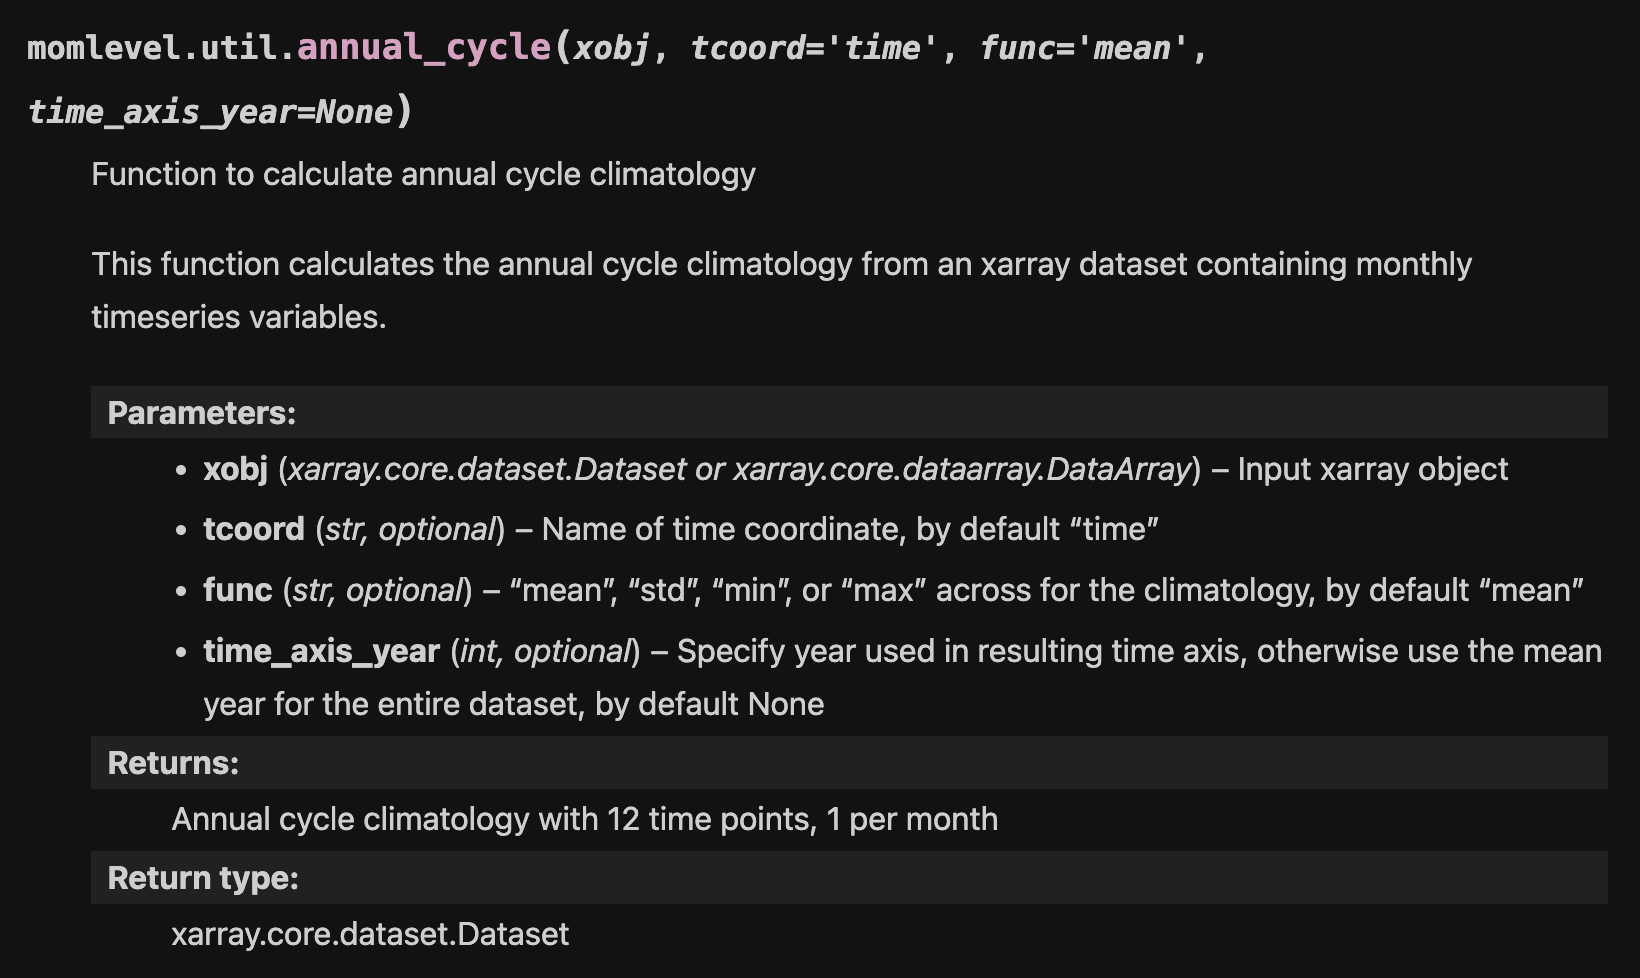

In [ ]:
SST_climatology = ml.util.annual_cycle(SST_monthly,tcoord='time')

In [ ]:
SST_climatology

#### OKAY --- One last thing you might want to do! It is common to be interested in __seasonal averages__ when comparing climate data. For example someone might be interested in "how much warmer have wintertime temperatures gotten in Pennsylvania over the past decade?".

#### In the Northern Hemisphere .... our winter is defined as the average over December, January, February (DJF), spring is defined as the average over March, April, May (MAM) ... and so on.

#### It turns out that we can use Xarray's `.groupby()` method to easily convert monthly data to a seasonal average over some period of interest:

In [ ]:
SST_seasonal = SST_monthly.groupby('time.season').mean(dim='time')

#### Examining our new SST_seasonal DataArray shows that we now have a time dimension called `season` with coordinate values of `'DJF' 'JJA' 'MAM' 'SON'` ! Wow that was easy!

In [ ]:
SST_seasonal

#### <span style="color:red"> Write code in the cell below that produces a global plot of the 1993 to 2022 wintertime (Northern Hemisphere winter) SST using your newly created `SST_seasonal` DataArray:

In [ ]:
sst_winter= SST_seasonal.sel(season='DJF')
sst_winter.plot()

### Now that you know how to work with > 1D climate data using Xarray, you are ready to start the fun of learning how to make visually appealing spatial maps! On to the next notebook ......

### <span style="color:red"> Do not forget that you must have answers for all the red cells in this notebook and add and push it to GitHub when complete!!

#### Shutting down your notebook (__don't do this yet!!__ These are just instructions for when class is over).
#### Before shutting down, save your notebook with the disc icon in the Notebook toolbar. Go to the the File menu and click Shut Down to close the browser table and Jupyter Lab itself.